# Redes neuronales junto con NeuralODEs

Vamos a mezclar los ejemplos vistos anteriormente, para ello vamos a crear una red neuronal la cual también pase por una NeuralODE

In [1]:
using Flux
using DifferentialEquations
using DiffEqFlux
using Plots
using Flux: train!
using Distributions

Comenzamos como simpre generando los dastos que vamos a utilizar

In [2]:
function Noise_Sine(x)
    return sin(2π*x) + rand(Normal(0,0.1))
end;

In [3]:
t_train = Float32.(hcat(-1:0.01:1...))
#t_train_normalized = Float32.((t_train .- mean(t_train)) ./ std(t_train))
y_train = Float32.(Noise_Sine.(t_train))
trange = t_train[1,:]
tspan = (t_train[1], t_train[end])

(-1.0f0, 1.0f0)

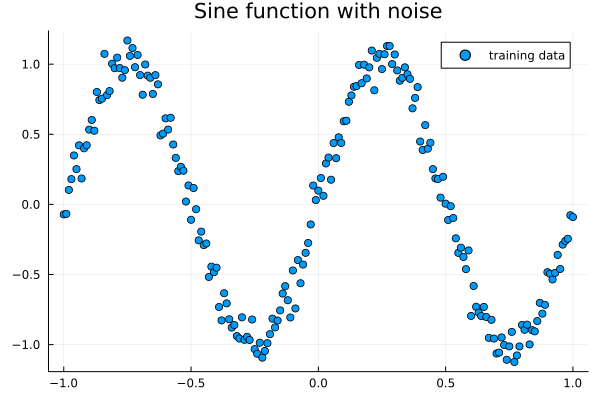

In [4]:
scatter(t_train[1,:], y_train[1,:], label="training data", title="Sine function with noise")

In [5]:
dudt = Chain(x -> 2π*cos.(2π.*x),
            Dense(1 => 30, relu),
            Dense(30 => 25, relu),
            Dense(25 => 1, tanh_fast))

Chain(
  var"#11#12"(),
  Dense(1 => 30, relu),                 # 60 parameters
  Dense(30 => 25, relu),                # 775 parameters
  Dense(25 => 1, tanh_fast),            # 26 parameters
)                   # Total: 6 arrays, 861 parameters, 3.738 KiB.

A esta NN la vamos a hacer pasar por una NerualODE y extraemos los paráemtros de este modelo

In [6]:
n_ode = NeuralODE(dudt, tspan, Tsit5(), saveat = trange, )
ps = Flux.params(n_ode)

Params([Float32[0.42118204, 0.2024, -0.23835331, -0.16506055, -0.18870512, -0.35393375, 0.116414264, -0.10191676, -0.09080454, -0.3483656  …  -0.40242448, 0.23947176, -0.39996403, 0.3490708, 0.2227877, 0.097659186, -0.4228266, -0.32423663, -0.23312186, 0.0]])

Creamos una función para crear las predicciones de la NODE empezando en el tiempo inicial t0.

In [7]:
t0 = Float32[0.0]
function predict_n_ode()
    n_ode(t0)
end

predict_n_ode (generic function with 1 method)

Creamos la función costo para esta red neruronal, igual que antes usamos mse

In [8]:
function loss_node()
    pred = predict_n_ode()
    pred = vcat(pred.u...)
    return mean(abs2, pred .- y_train[1,:])
end

loss_node (generic function with 1 method)

Veamos como se ve inicialente las predicciones de la red neuronal

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(1 => 30, relu)
│   summary(x) = 1-element Vector{Float64}
└ @ Flux C:\Users\Propietario\.julia\packages\Flux\n3cOc\src\layers\stateless.jl:60


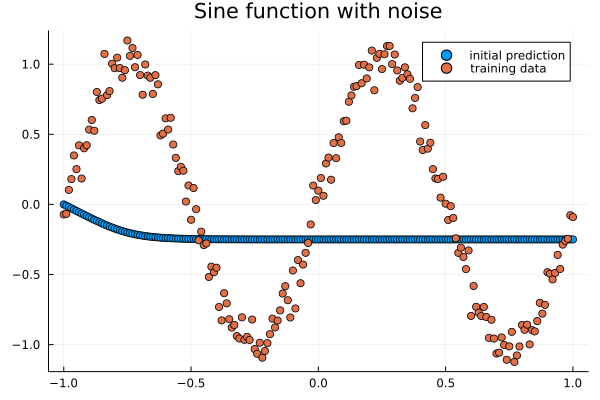

In [9]:
pred0 = predict_n_ode()
scatter(trange, pred0[1,:], label="initial prediction", title="Sine function with noise")
scatter!(trange, y_train[1,:], label = "training data")

Seteamos la cantidad de épocas a entrenar, el ratio de aprendizaje y el modelo de optimización que vamos a utilizar. Además creamos la función callback para obtener información de cada época de entrenamiento

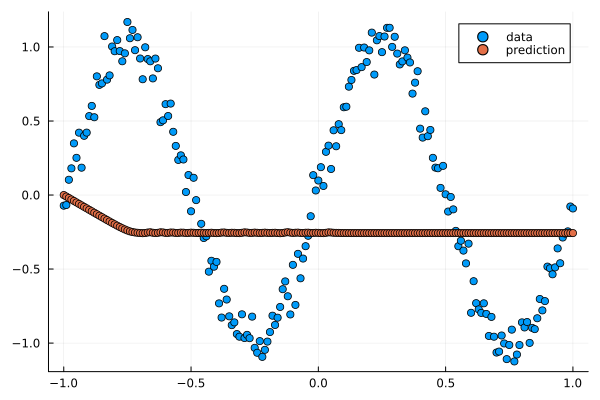

Epoch: 100 | Loss: 0.56997025


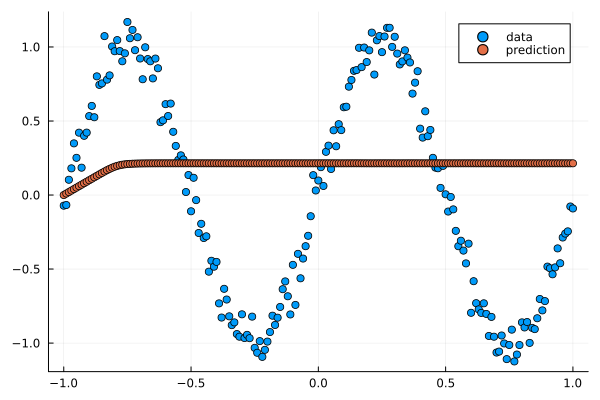

Epoch: 200 | Loss: 0.57197183

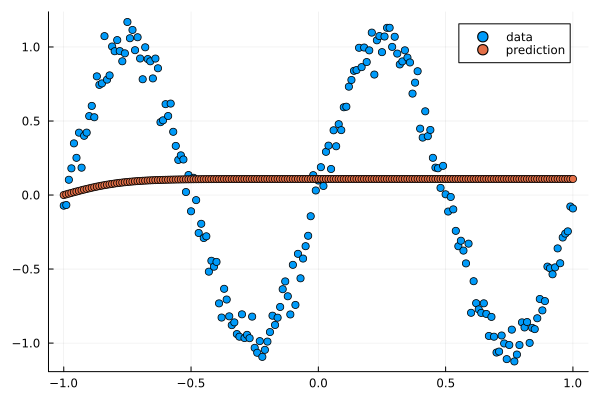


Epoch: 300 | Loss: 0.5400822

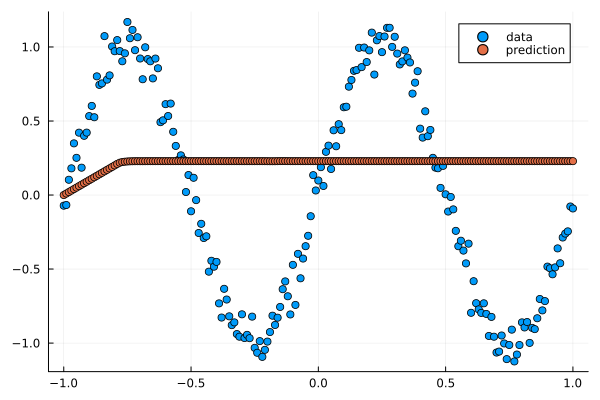


Epoch: 400 | Loss: 0.57880545


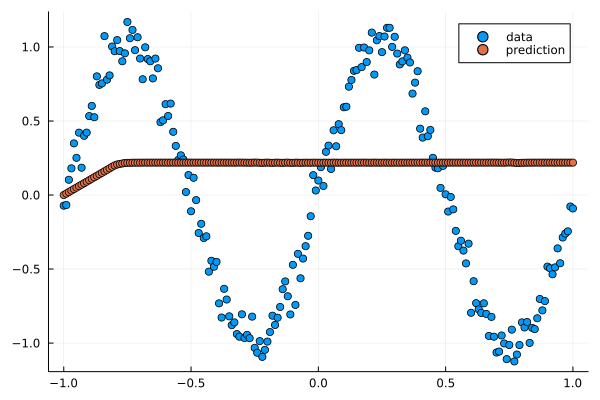

Epoch: 500 | Loss: 0.57363397

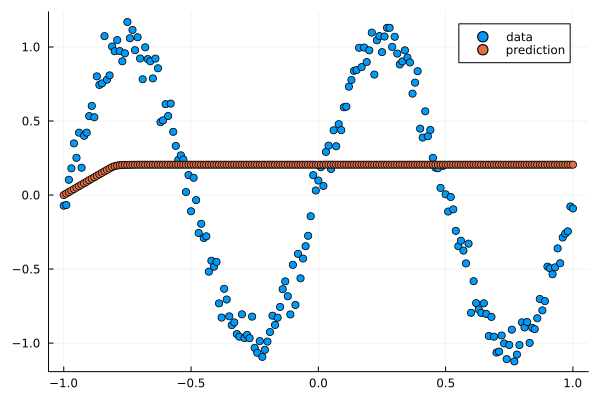


Epoch: 600 | Loss: 0.5670674


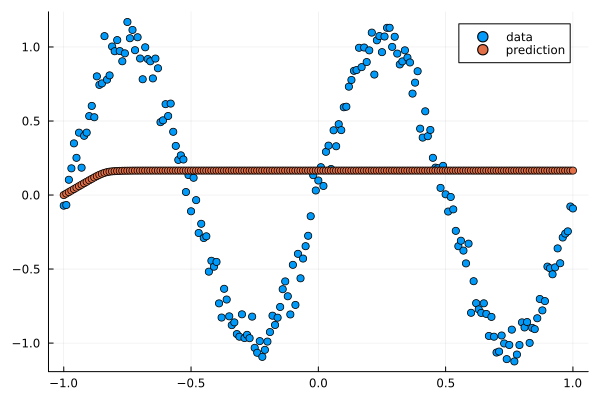

Epoch: 700 | Loss: 0.5508275


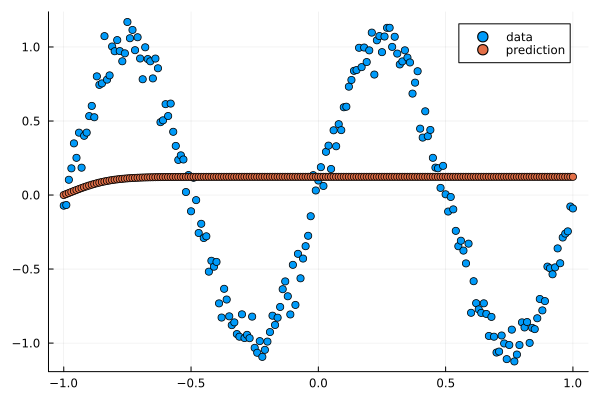

Epoch: 800 | Loss: 0.54117846


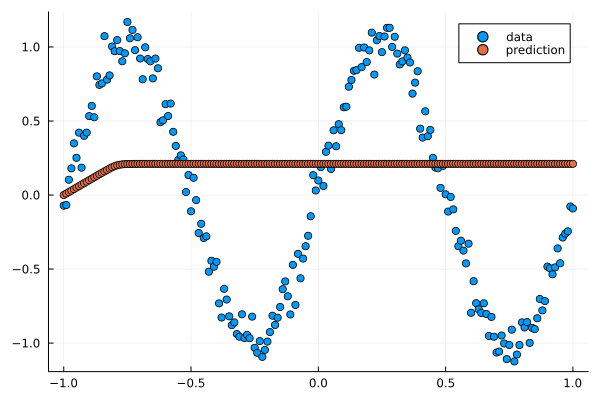

Epoch: 900 | Loss: 0.56989586

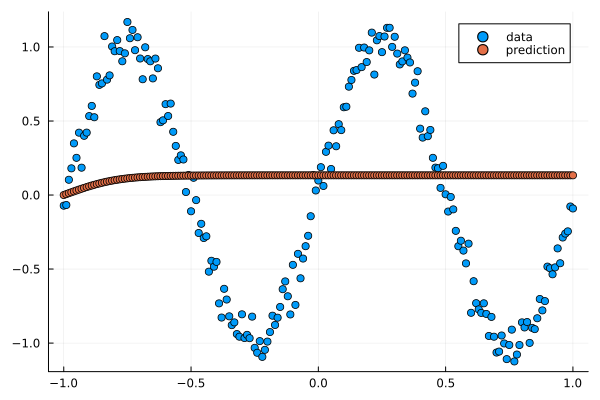


Epoch: 1000 | Loss: 0.54603744


In [10]:
data = Iterators.repeated((), 1000)
learning_rate = 0.01
opt = ADAM(learning_rate)
iter = 0
losses = []
cb = function () #callback function to observe training
  global iter += 1
  actual_loss = loss_node()
  if(iter%100 == 0)
    cur_pred = predict_n_ode()
    println("Epoch: $iter | Loss: $actual_loss")
    pl = scatter(trange,y_train[1,:],label="data")
    scatter!(pl,trange,cur_pred[1,:],label="prediction")
    display(plot(pl))
  end
  push!(losses, actual_loss)
end

Flux.train!(loss_node, ps, data, opt, cb = cb)
